In [ ]:
import os
from glob import glob
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import time
import h5py

In [ ]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist, infer
from cplxdist import CplxNormal

import matplotlib.pyplot as plt
import arviz as az
import corner

In [ ]:
import antiglitch

In [36]:
numpyro.set_host_device_count(4)

In [37]:
datadir = 'data'

In [38]:
# Frequency-domain signal model
freqs = jnp.linspace(0, np.pi, 513)

@jax.jit
def fsignal(freqs, f0, gbw):
    return jnp.exp(-0.5*gbw*(jnp.log(freqs) - jnp.log(f0))**2)

In [148]:
def glitch_model(freqs, invasd, data=None):
    amp = numpyro.sample("amp", dist.Normal(0, 200))
    phase = 0. # numpyro.sample("phase", dist.Uniform(-jnp.pi, jnp.pi))
    #sigma = numpyro.sample("sigma", dist.HalfNormal(2))
    t = numpyro.sample("time", dist.Normal(0, 20))
    f0 = numpyro.sample('f0', dist.Uniform(0.0025, 0.3))
    gbw = numpyro.sample('gbw', dist.Uniform(0.25, 8.))

    with numpyro.plate("data", len(data)):
        numpyro.sample("y", CplxNormal(amp*jnp.exp(1.j*(-t*freqs+phase))*invasd*fsignal(freqs, f0, gbw), 0.5), obs=data)

In [161]:
def glitch_model(freqs, invasd, data=None):
    amp_r = numpyro.sample("amp_r", dist.Normal(0, 200))
    amp_i = numpyro.sample("amp_i", dist.Normal(0, 50))
    #sigma = numpyro.sample("sigma", dist.HalfNormal(2))
    t = numpyro.sample("time", dist.Normal(0, 20))
    f0 = numpyro.sample('f0', dist.Uniform(0.0025, 0.3))
    gbw = numpyro.sample('gbw', dist.Uniform(0.25, 8.))

    with numpyro.plate("data", len(data)):
        numpyro.sample("y", CplxNormal((amp_r+1.j*amp_i)*jnp.exp(-1.j*t*freqs)*invasd*fsignal(freqs, f0, gbw), 0.5), obs=data)

In [162]:
sampler = infer.MCMC(
    infer.NUTS(glitch_model),
    num_warmup=4000,
    num_samples=2000,
    num_chains=4,
    progress_bar=True,
)

In [281]:
num_svi_steps = 50000

In [282]:
from numpyro.infer import SVI, Trace_ELBO, autoguide
optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = autoguide.AutoDelta(glitch_model)
svi = SVI(glitch_model, guide, optimizer, loss=Trace_ELBO())

In [283]:
svi_result = svi.run(jax.random.PRNGKey(0), num_svi_steps, freqs[1:], invasd[1:], data=fglitch[1:])
params, losses = svi_result.params, svi_result.losses

100%|██████████| 50000/50000 [00:33<00:00, 1498.64it/s, init loss: 8654.7402, avg. loss [47501-50000]: 4498.6328]


In [269]:
ifo, key, num = ('L1', 'blip', 45)
npz = np.load(f"{datadir}/{ifo}-{key}-{num:04d}.npz")

invasd, whts = glitchmodel.extract_glitch(npz)
fglitch = rfft(np.roll(whts, -len(whts)//2))

%time sampler.run(jax.random.PRNGKey(0), freqs[1:], invasd[1:], data=fglitch[1:])

/nfshome/store01/users/andrew.lundgren/detchar/GlitchSearch/glitchmodel.py:21: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

CPU times: user 11.2 s, sys: 122 ms, total: 11.4 s
Wall time: 7.41 s


In [278]:
itrace = az.from_numpyro(sampler)
summ = az.summary(itrace, kind='stats')

In [263]:
inf_data = itrace
inf = {key: float(np.mean(inf_data.posterior[key]))
        for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
cpamp = inf['amp_r']+1.j*inf['amp_i']
inf['amp'] = np.abs(cpamp)
inf['phase'] = np.angle(cpamp)

/nfshome/store01/users/andrew.lundgren/detchar/GlitchSearch/glitchmodel.py:21: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]


(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

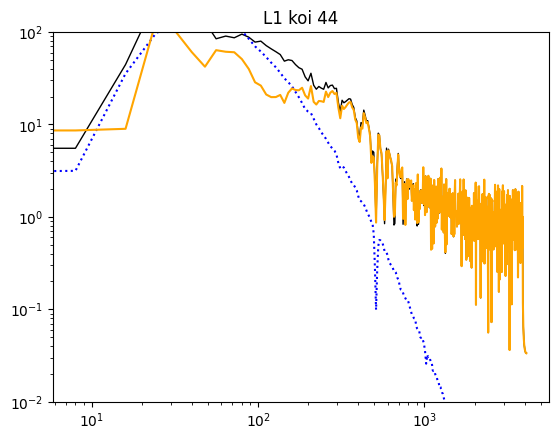

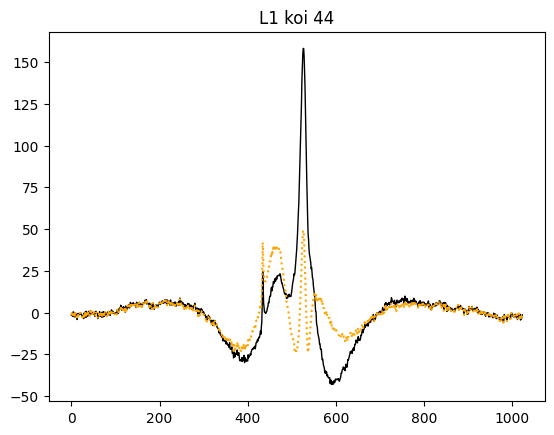

In [238]:
snip = glitchmodel.Snippet(ifo, key, num)
snip.set_infer(inf)
snip.plot()

In [239]:
print(az.summary(itrace, kind='stats'))

            mean      sd     hdi_3%    hdi_97%
amp_i   5776.369  33.006   5719.725   5843.083
amp_r  13042.500  72.856  12901.140  13174.732
f0         0.005   0.000      0.005      0.005
gbw        0.766   0.005      0.757      0.774
time      18.863   0.046     18.776     18.947


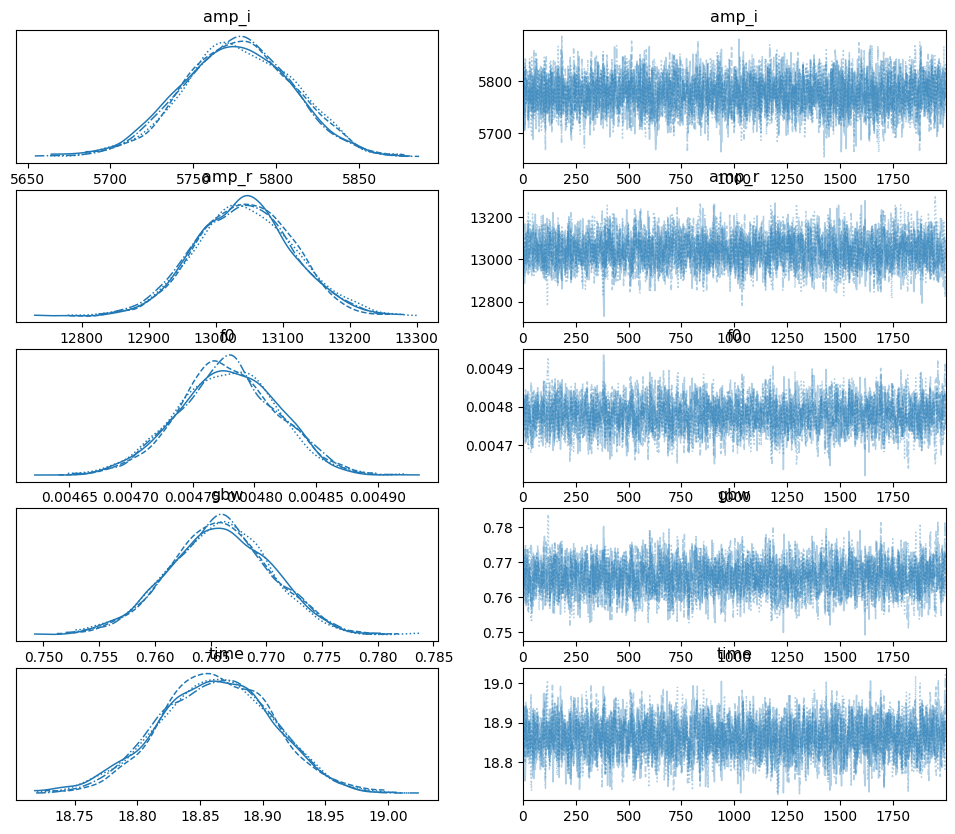

In [240]:
az.plot_trace(itrace);

In [ ]:
fig = plt.figure()
ax = fig.gca()
for idx in range(6):
    inf_data = koi_traces[idx]
    az.plot_pair(inf_data, var_names=["phase", "amp"], ax=ax, kind='scatter')

In [ ]:
fig = plt.figure()
ax = fig.gca()
for idx in range(6):
    inf_data = koi_traces[idx]
    az.plot_pair(inf_data, var_names=["f0", "gbw"], ax=ax, kind='scatter')

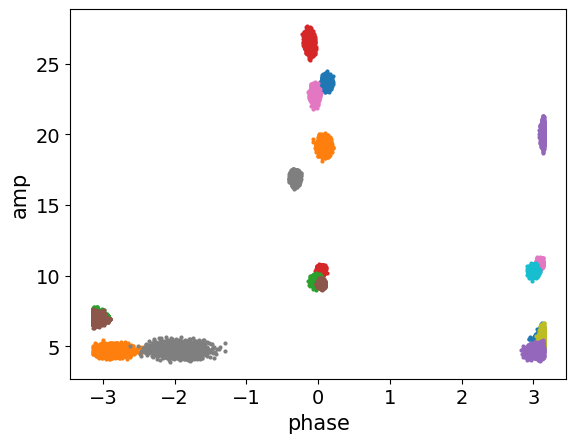

In [368]:
fig = plt.figure()
ax = fig.gca()
for idx in range(6):
    inf_data = blip_traces[idx]
    az.plot_pair(inf_data, var_names=["phase", "amp"], ax=ax, kind='scatter')
    inf_data = koi_traces[idx]
    az.plot_pair(inf_data, var_names=["phase", "amp"], ax=ax, kind='scatter')
    inf_data = tomte_traces[idx]
    az.plot_pair(inf_data, var_names=["phase", "amp"], ax=ax, kind='scatter')

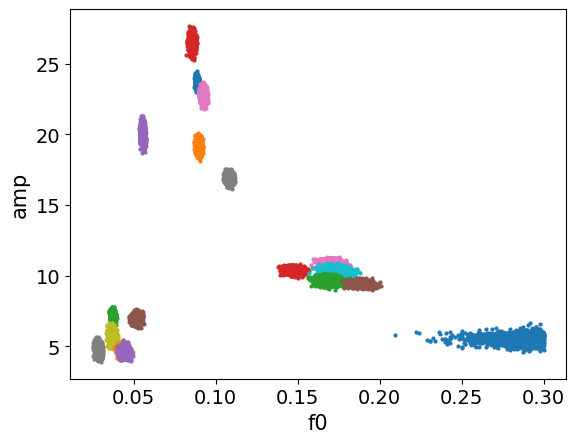

In [376]:
fig = plt.figure()
ax = fig.gca()
for idx in range(6):
    inf_data = blip_traces[idx]
    az.plot_pair(inf_data, var_names=["f0", "amp"], ax=ax, kind='scatter')
    inf_data = koi_traces[idx]
    az.plot_pair(inf_data, var_names=["f0", "amp"], ax=ax, kind='scatter')
    inf_data = tomte_traces[idx]
    az.plot_pair(inf_data, var_names=["f0", "amp"], ax=ax, kind='scatter')

## Layout of paper

 1. Introduction; glitches are bad
 2. Layout types of glitches and FD model
 3. Details of inference
 4. Results on three glitch classes; clusters, amplitudes
 5. Interaction with BBH templates; match
 6. Sketch of practical use; how to use in a search
 7. Analysis of highmass events
 8. Conclusion

In [41]:
result = np.load('L1-blip-results.npz', allow_pickle=True)['result']

In [43]:
result.keys()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'